In [1]:
import os

data_dir = './jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

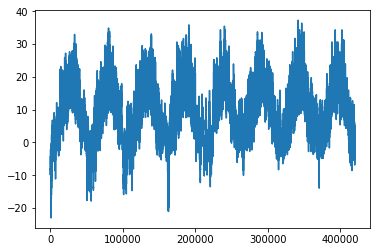

In [5]:
from matplotlib import  pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

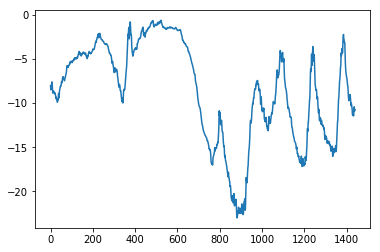

In [6]:
plt.plot(range(1440), temp[:1440])

In [3]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [4]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [5]:
lookback = 1440
step = 6
delay = 144
batch_size = 128
train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step, 
                      batch_size=batch_size)

val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, shuffle=True, step=step, 
                      batch_size=batch_size)

test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, shuffle=True, step=step, 
                      batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [21]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.28706624352615373


In [22]:
celsius_mae = 0.29 * std[1]
celsius_mae

2.5672247338393395

In [24]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
                

history = model.fit_generator(
    train_gen, 
    steps_per_epoch=500,
    epochs=20,
    validation_data = val_gen,
    validation_steps = val_steps)

Epoch 1/20
500/500 [==============================] - 15s 31ms/step - loss: 1.2200 - val_loss: 0.5875
Epoch 2/20
500/500 [==============================] - 14s 27ms/step - loss: 0.4206 - val_loss: 0.3158
Epoch 3/20
500/500 [==============================] - 14s 27ms/step - loss: 0.2932 - val_loss: 0.3108
Epoch 4/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2703 - val_loss: 0.3119
Epoch 5/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2568 - val_loss: 0.3330
Epoch 6/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2486 - val_loss: 0.3184
Epoch 7/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2415 - val_loss: 0.3090
Epoch 8/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2353 - val_loss: 0.3375
Epoch 9/20
500/500 [==============================] - 13s 27ms/step - loss: 0.2291 - val_loss: 0.3196
Epoch 10/20
500/500 [==============================] - 14s 27ms/step - loss: 0.226

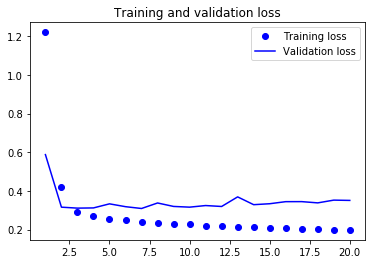

In [27]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

GRU를 사용한 모델을 훈련하고 평가하기

In [30]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(
    train_gen, 
    steps_per_epoch=500,
    epochs=20,
    validation_data = val_gen,
    validation_steps = val_steps)

Epoch 1/20
500/500 [==============================] - 176s 352ms/step - loss: 0.3013 - val_loss: 0.2747
Epoch 2/20
500/500 [==============================] - 172s 344ms/step - loss: 0.2854 - val_loss: 0.2768
Epoch 3/20
500/500 [==============================] - 176s 352ms/step - loss: 0.2795 - val_loss: 0.2632
Epoch 4/20
500/500 [==============================] - 172s 344ms/step - loss: 0.2734 - val_loss: 0.2664
Epoch 5/20
500/500 [==============================] - 171s 342ms/step - loss: 0.2671 - val_loss: 0.2644
Epoch 6/20
500/500 [==============================] - 173s 346ms/step - loss: 0.2635 - val_loss: 0.2647
Epoch 7/20
500/500 [==============================] - 173s 346ms/step - loss: 0.2577 - val_loss: 0.2783
Epoch 8/20
500/500 [==============================] - 172s 343ms/step - loss: 0.2530 - val_loss: 0.2762
Epoch 9/20
500/500 [==============================] - 172s 344ms/step - loss: 0.2486 - val_loss: 0.2663
Epoch 10/20
500/500 [==============================] - 172s 345m

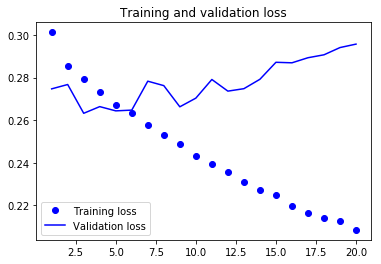

In [31]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

드롭아웃 규제된 GRU

In [32]:
model = Sequential()
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(
    train_gen, 
    steps_per_epoch=500,
    epochs=40,
    validation_data = val_gen,
    validation_steps = val_steps)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/40
500/500 [==============================] - 195s 390ms/step - loss: 0.3392 - val_loss: 0.2877
Epoch 2/40
500/500 [==============================] - 192s 384ms/step - loss: 0.3157 - val_loss: 0.2738
Epoch 3/40
500/500 [==============================] - 193s 386ms/step - loss: 0.3098 - val_loss: 0.2756
Epoch 4/40
500/500 [==============================] - 193s 385ms/step - loss: 0.3037 - val_loss: 0.2734
Epoch 5/40
500/500 [==============================] - 194s 388ms/step - loss: 0.3009 - val_loss: 0.2714
Epoch 6/40
500/500 [==============================] - 191s 382ms/step - loss: 0.2977 - val_loss: 0.2704
Epoch 7/40
500/500 [==============================] - 191s 382ms/step - loss: 0.2954 - val_loss: 0.2668
Epoch 8/40
500/500 [==============================] - 194s 387ms/step - loss: 0.2945 - val_loss: 0.2692
Epoch 9/40
500/500 [==============================] -

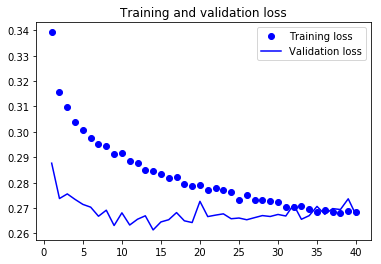

In [33]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

드롭아웃 규제 및 스태킹(stacking, 적재)한 GRU 모델

In [6]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5, return_sequences=True, input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu', dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(
    train_gen, 
    steps_per_epoch=500,
    epochs=40,
    validation_data = val_gen,
    validation_steps = val_steps)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/40
500/500 [==============================] - 384s 768ms/step - loss: 0.3344 - val_loss: 0.2760
Epoch 2/40
500/500 [==============================] - 381s 762ms/step - loss: 0.3134 - val_loss: 0.2717
Epoch 3/40
500/500 [==============================] - 384s 768ms/step - loss: 0.3072 - val_loss: 0.2731
Epoch 4/40
500/500 [==============================] - 387s 773ms/step - loss: 0.3005 - val_loss: 0.2718
Epoch 5/40
500/500 [==============================] - 389s 778ms/step - loss: 0.2988 - val_loss: 0.2686
Epoch 6/40
500/500 [==============================] - 388s 775ms/step - loss: 0.2953 - val_loss: 0.2745
Epoch 7/40
500/500 [==============================] - 385s 770ms/step - loss: 0.2930 - val_loss: 0.2689
Epoch 8/40
500/500 [=================

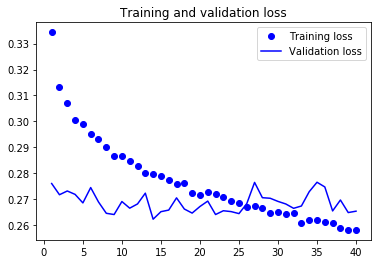

In [9]:
from matplotlib import pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

거꾸로 된 시퀸스 사용한 LSTM

In [13]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
maxlen = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = max_features)

x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['acc'])
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size = 128,
    validation_split = 0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 121s 6ms/step - loss: 0.4890 - acc: 0.7677 - val_loss: 0.3535 - val_acc: 0.8642
Epoch 2/10
20000/20000 [==============================] - 120s 6ms/step - loss: 0.3113 - acc: 0.8811 - val_loss: 0.3322 - val_acc: 0.8630
Epoch 3/10
20000/20000 [==============================] - 120s 6ms/step - loss: 0.2588 - acc: 0.9046 - val_loss: 0.3399 - val_acc: 0.8578
Epoch 4/10
20000/20000 [==============================] - 119s 6ms/step - loss: 0.2204 - acc: 0.9191 - val_loss: 0.3195 - val_acc: 0.8756
Epoch 5/10
20000/20000 [==============================] - 118s 6ms/step - loss: 0.1947 - acc: 0.9326 - val_loss: 0.3515 - val_acc: 0.8752
Epoch 6/10
20000/20000 [==============================] - 119s 6ms/step - loss: 0.1772 - acc: 0.9376 - val_loss: 0.3531 - val_acc: 0.8762
Epoch 7/10
20000/20000 [==============================] - 118s 6ms/step - loss: 0.1692 - acc: 0.9443 - val_loss: 0.3882 - v

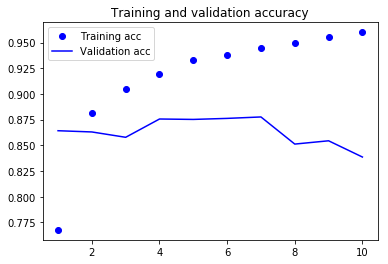

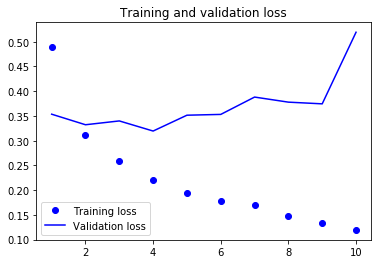

In [14]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

양방향 LSTM

In [16]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['acc'])
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size = 128,
    validation_split = 0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 230s 12ms/step - loss: 0.5586 - acc: 0.7169 - val_loss: 0.3998 - val_acc: 0.8460
Epoch 2/10
20000/20000 [==============================] - 226s 11ms/step - loss: 0.3303 - acc: 0.8706 - val_loss: 0.3175 - val_acc: 0.8852
Epoch 3/10
20000/20000 [==============================] - 228s 11ms/step - loss: 0.2645 - acc: 0.9020 - val_loss: 0.4729 - val_acc: 0.8510
Epoch 4/10
20000/20000 [==============================] - 224s 11ms/step - loss: 0.2325 - acc: 0.9158 - val_loss: 0.3140 - val_acc: 0.8832
Epoch 5/10
20000/20000 [==============================] - 227s 11ms/step - loss: 0.2064 - acc: 0.9271 - val_loss: 0.3373 - val_acc: 0.8860
Epoch 6/10
20000/20000 [==============================] - 228s 11ms/step - loss: 0.1909 - acc: 0.9331 - val_loss: 0.4382 - val_acc: 0.8250
Epoch 7/10
20000/20000 [==============================] - 233s 12ms/step - loss: 0.1714 - acc: 0.9421 - val_loss: 0.4

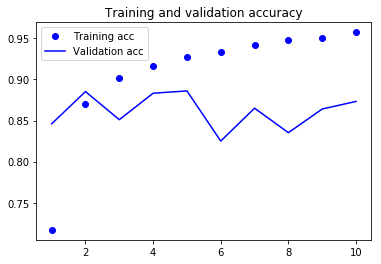

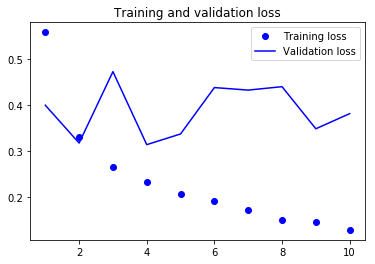

In [17]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

양방향 GRU

In [19]:
model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(
    train_gen, 
    steps_per_epoch=500,
    epochs=40,
    validation_data = val_gen,
    validation_steps = val_steps)

Epoch 1/40
500/500 [==============================] - 322s 645ms/step - loss: 0.2928 - val_loss: 0.2860
Epoch 2/40
500/500 [==============================] - 353s 707ms/step - loss: 0.2757 - val_loss: 0.2725
Epoch 3/40
500/500 [==============================] - 516s 1s/step - loss: 0.2654 - val_loss: 0.2773
Epoch 4/40
500/500 [==============================] - 517s 1s/step - loss: 0.2617 - val_loss: 0.2696
Epoch 5/40
500/500 [==============================] - 516s 1s/step - loss: 0.2560 - val_loss: 0.2705
Epoch 6/40
500/500 [==============================] - 517s 1s/step - loss: 0.2505 - val_loss: 0.2904
Epoch 7/40
500/500 [==============================] - 517s 1s/step - loss: 0.2443 - val_loss: 0.2851
Epoch 8/40
500/500 [==============================] - 517s 1s/step - loss: 0.2377 - val_loss: 0.2811
Epoch 9/40
500/500 [==============================] - 516s 1s/step - loss: 0.2319 - val_loss: 0.2917
Epoch 10/40
500/500 [==============================] - 516s 1s/step - loss: 0.2256 - 

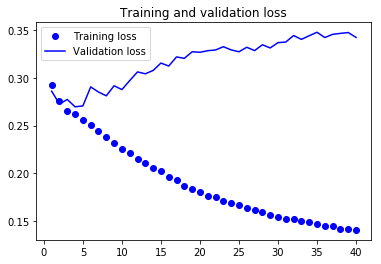

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()